In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Phase 1

In [17]:
df = pd.read_csv('hotel_bookings.csv')

print(df.describe())
print(df.info())

         is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000            

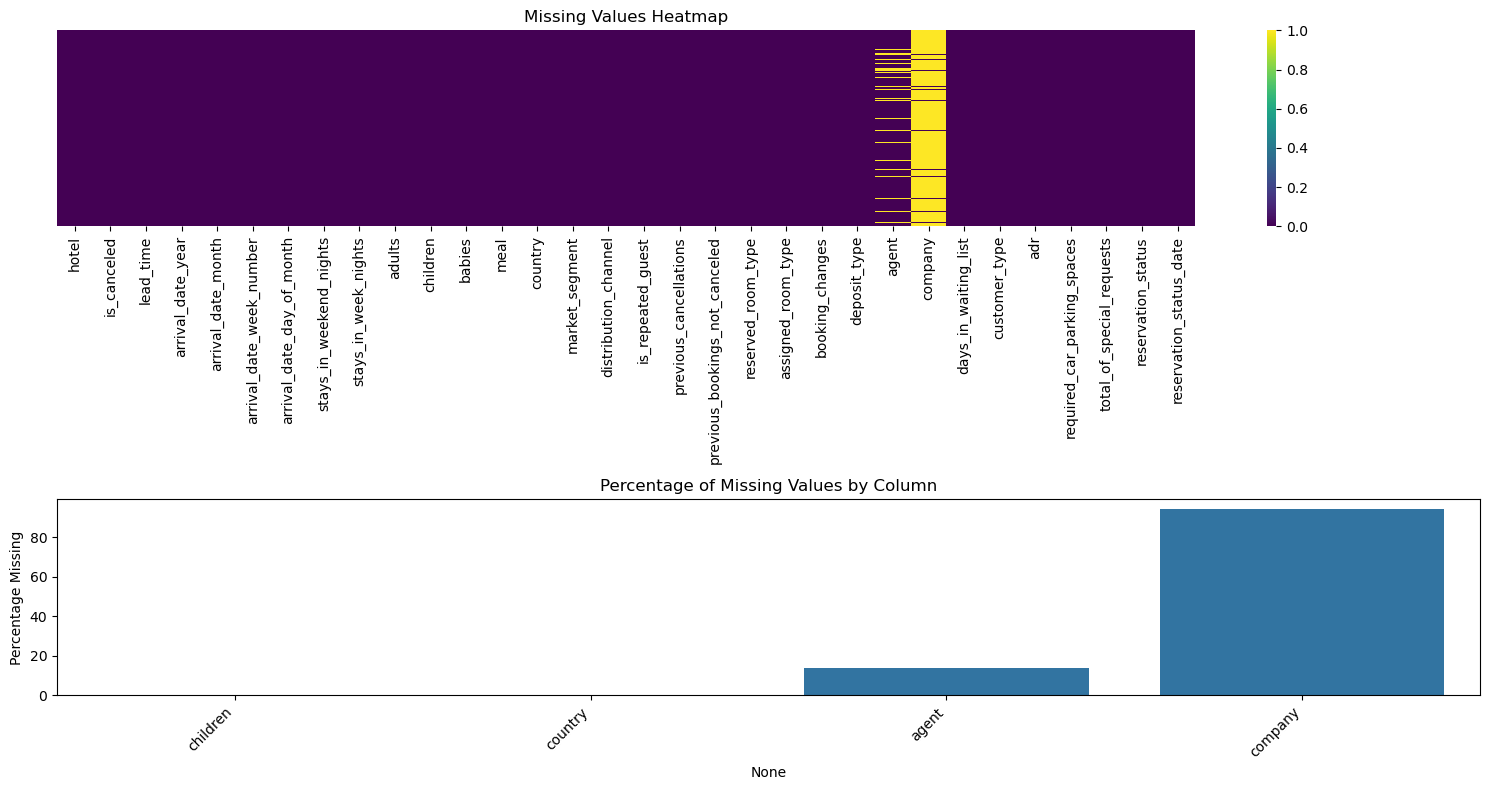


Missing values percentage for each column:
children: 0.00%
country: 0.41%
agent: 13.69%
company: 94.31%


In [18]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Values Heatmap')

plt.subplot(2, 1, 2)
missing_percentages = (df.isnull().sum() / len(df)) * 100
missing_percentages = missing_percentages[missing_percentages > 0].sort_values(ascending=True)
sns.barplot(x=missing_percentages.index, y=missing_percentages.values)
plt.title('Percentage of Missing Values by Column')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage Missing')

plt.tight_layout()
plt.show()

# Print exact percentages of missing values
print("\nMissing values percentage for each column:")
for column in missing_percentages.index:
    print(f"{column}: {missing_percentages[column]:.2f}%")

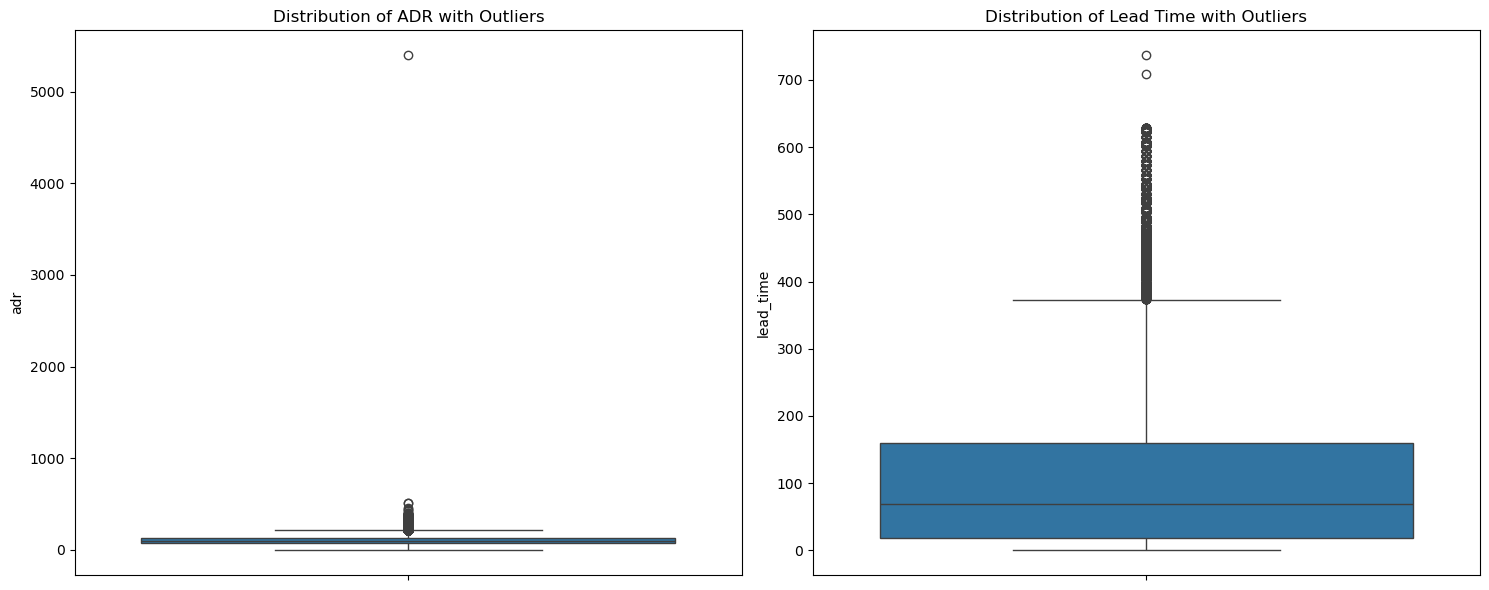


ADR Outliers Summary:
Number of outliers: 3793
Percentage of outliers: 3.18%
Range for non-outliers: -15.77 to 211.06

Lead Time Outliers Summary:
Number of outliers: 3005
Percentage of outliers: 2.52%
Range for non-outliers: -195.00 to 373.00


In [19]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, y='adr')
plt.title('Distribution of ADR with Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='lead_time')
plt.title('Distribution of Lead Time with Outliers')

plt.tight_layout()
plt.show()

# Calculate outliers using IQR method
def get_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers, lower_bound, upper_bound

# Get outliers for ADR and lead_time
adr_outliers, adr_lower, adr_upper = get_outliers(df, 'adr')
lead_time_outliers, lead_lower, lead_upper = get_outliers(df, 'lead_time')

print("\nADR Outliers Summary:")
print(f"Number of outliers: {len(adr_outliers)}")
print(f"Percentage of outliers: {(len(adr_outliers)/len(df))*100:.2f}%")
print(f"Range for non-outliers: {adr_lower:.2f} to {adr_upper:.2f}")

print("\nLead Time Outliers Summary:")
print(f"Number of outliers: {len(lead_time_outliers)}")
print(f"Percentage of outliers: {(len(lead_time_outliers)/len(df))*100:.2f}%")
print(f"Range for non-outliers: {lead_lower:.2f} to {lead_upper:.2f}")

### What did we find?
- Most of `company` column is missing → we can drop the entire column.  
- 16% of `agent` column is missing → we can replace missing values with the mean.  
- About 0.4% of `country` column is missing → we can drop those rows or impute with the mode (most frequent category).
- there is about 3% outliers in ADR and in Lead Time columns that we can use robust scaling methods or if they are extreme outliers, errors or noise data we can drop them 


## phase 2

In [20]:
df_cleaned = df.copy()

# Replace missing values in 'company' with 0
df_cleaned['company'] = df_cleaned['company'].fillna(0)

# Replace missing values in 'agent' with 0
df_cleaned['agent'] = df_cleaned['agent'].fillna(0)

# Replace missing values in 'country' with mode
df_cleaned['country'] = df_cleaned['country'].fillna(df_cleaned['country'].mode()[0])

# Replace missing values in 'children' with the median
df_cleaned['children'] = df_cleaned['children'].fillna(df_cleaned['children'].median())

In [21]:
# Remove duplicates and calculate how many were removed
initial_rows = len(df_cleaned)
df_cleaned = df_cleaned.drop_duplicates()
duplicates_removed = initial_rows - len(df_cleaned)

# Cap outliers
# For ADR, values above 1000 are likely errors or rare cases, so capping them reduces their impact.
df_cleaned['adr'] = df_cleaned['adr'].clip(upper=1000)

# convert to datetime format
df_cleaned['reservation_status_date'] = pd.to_datetime(df_cleaned['reservation_status_date'])

# Print summary of changes
print("Data Cleaning Summary:")
print("-" * 50)
print(f"Original number of rows: {initial_rows}")
print(f"Duplicate rows removed: {duplicates_removed}")
print(f"Final number of rows: {len(df_cleaned)}")
print("\nMissing values after cleaning:")
print(df_cleaned.isnull().sum()[df_cleaned.isnull().sum() > 0])
print("\nData types after cleaning:")
print(df_cleaned.dtypes)

Data Cleaning Summary:
--------------------------------------------------
Original number of rows: 119390
Duplicate rows removed: 32013
Final number of rows: 87377

Missing values after cleaning:
Series([], dtype: int64)

Data types after cleaning:
hotel                                     object
is_canceled                                int64
lead_time                                  int64
arrival_date_year                          int64
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                 float64
babies                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_cha

## Phase 3

In [22]:
from sklearn.model_selection import train_test_split

# new features
df_cleaned['total_guests'] = df_cleaned['adults'] + df_cleaned['children'] + df_cleaned['babies']
df_cleaned['total_nights'] = df_cleaned['stays_in_weekend_nights'] + df_cleaned['stays_in_week_nights'] 
df_cleaned['is_family'] = ((df_cleaned['children'] > 0) | (df_cleaned['babies'] > 0)).astype(int)

# For low cardinality features, use one-hot encoding
categorical_cols_low = ['meal', 'market_segment']
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols_low)

# For country (high cardinality), use frequency encoding
country_freq = df_cleaned['country'].value_counts(normalize=True)
rare_countries = country_freq[country_freq < 0.01].index
df_encoded['country'] = df_cleaned['country'].apply(lambda x: 'Other' if x in rare_countries else x)
df_encoded = pd.get_dummies(df_encoded, columns=['country'])

# Remove reservation status columns to prevent data leakage
df_cleaned = df_cleaned.drop(['reservation_status', 'reservation_status_date'], axis=1)

# Split into training and testing sets
X = df_encoded.drop('is_canceled', axis=1)
y = df_encoded['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (69901, 59)
Testing set shape: (17476, 59)
